In [1]:
import torch
import matplotlib.pyplot as plt
from mlrg.hmc import HMCSampler
from rgflow import RGLayer

### Phi4 Model Sampling

In [3]:
class Phi4Model(torch.nn.Module):
    ''' phi4 model energy 
        E = (1/2) sum_<ij> |x_i-x_j|^2 + (r/2) sum_i |x_i|^2 + (u/4) sum_i |x_i|^4
        
        Parameters:
            r :: real - (initial) value of r
            u :: real - (initial) value of u '''
    def __init__(self, r=0., u=1.):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        self.u = torch.nn.Parameter(torch.tensor(u))
        
    def extra_repr(self):
        return f'r={self.r.item()}, u={self.u.item()}'
        
    def clone(self):
        mdl = type(self)()
        mdl.load_state_dict(self.state_dict())
        return mdl
        
    def forward(self, x):
        energy = 0.
        for axis in range(2, x.dim()):
            dx2 = (x.roll(1,axis) - x).square().sum(1)
            energy = energy + dx2 / 2
        x2 = x.square().sum(1)
        energy = energy + self.r * x2 / 2 + self.u * x2.square() / 4
        energy = energy.view(energy.shape[:1]+(-1,)).sum(-1)
        return energy

In [2]:
class GaussianModel(torch.nn.Module):
    ''' phi4 model energy 
        E = (1/2) sum_<ij> |x_i-x_j|^2 + (r/2) sum_i |x_i|^2
        
        Parameters:
            r :: real - (initial) value of 
            '''
    def __init__(self, r=0.):
        super().__init__()
        self.r = torch.nn.Parameter(torch.tensor(r))
        
    def extra_repr(self):
        return f'r={self.r.item()}'
        
    def clone(self):
        mdl = type(self)()
        mdl.load_state_dict(self.state_dict())
        return mdl
        
    def forward(self, x):
        energy = 0.
        for axis in range(2, x.dim()):
            dx2 = (x.roll(1,axis) - x).square().sum(1)
            energy = energy + dx2 / 2
        x2 = x.square().sum(1)
        energy = energy + self.r * x2 / 2
        energy = energy.view(energy.shape[:1]+(-1,)).sum(-1)
        return energy

In [14]:
mdl = GaussianModel().requires_grad_(False)
for p in mdl.parameters():
    print(p)

Parameter containing:
tensor(0.)


In [36]:
hmc = HMCSampler(GaussianModel(r=3.), [5,1,64,64])

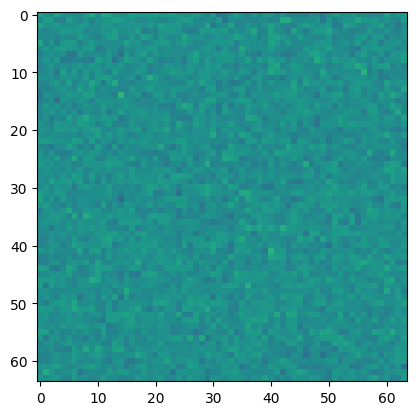

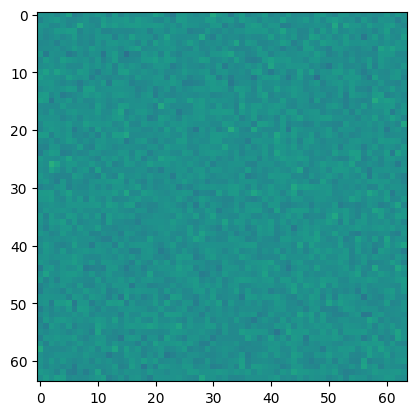

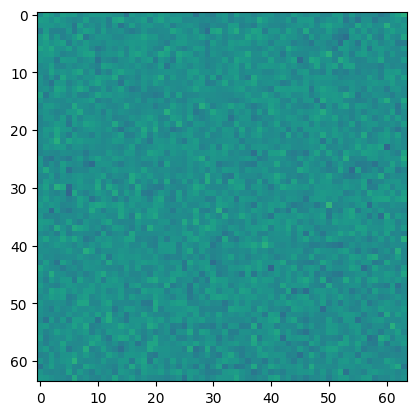

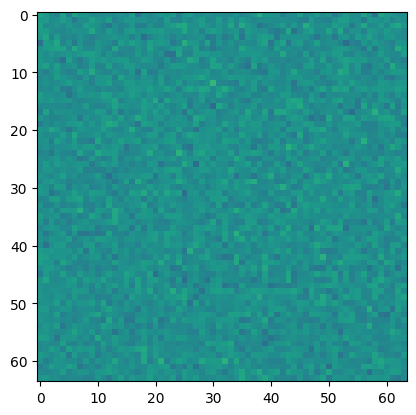

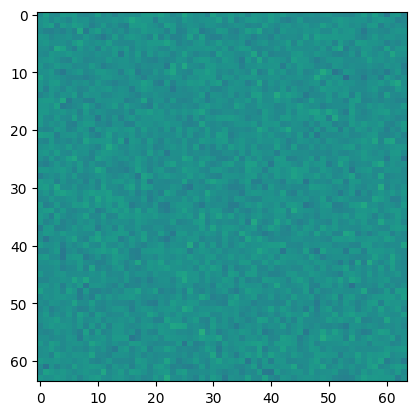

In [37]:
for x in hmc.sample():
    plt.figure()
    plt.imshow(x.squeeze(), vmin=-1, vmax=1)

### RG Layer Demo

In [6]:
hmc = HMCSampler(Phi4Model(r=-1.), [3,1,8,8])

In [7]:
rg = RGLayer([8, 8], 1)

In [8]:
x = hmc.sample()

In [9]:
y, z = rg.encode(x)

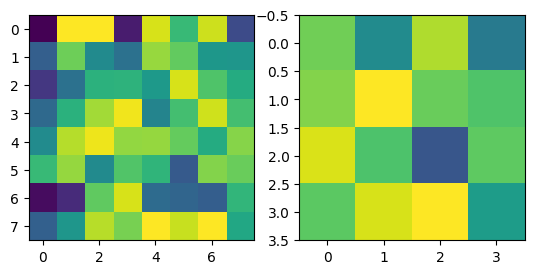

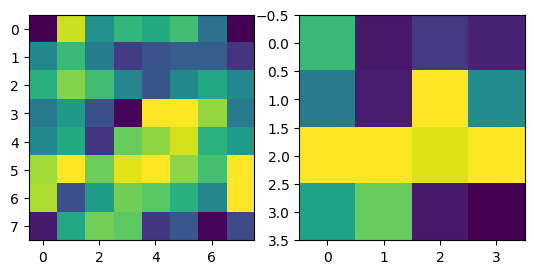

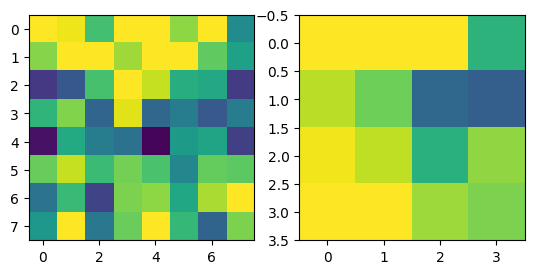

In [10]:
for x_, y_ in zip(x, y):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x_.detach().squeeze(), vmin=-1, vmax=1)
    ax2.imshow(y_.detach().squeeze(), vmin=-1, vmax=1)

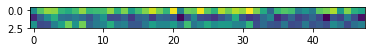

In [208]:
plt.imshow(z.detach().squeeze())

### RG Learner

In [21]:
class RGLearner(torch.nn.Module):
    def __init__(self, uv_model, ir_model, device, uv_shape, dim, base_dist='Normal', **kwargs):
        super().__init__()
        self.uv_model = uv_model.requires_grad_(False)
        # self.ir_model = uv_model.clone().requires_grad_(True)
        self.ir_model = ir_model.requires_grad_(True)
        self.rglayer = RGLayer(uv_shape, device, dim, **kwargs)
        ir_shape = self.rglayer.partitioner.out_shape
        self.ir_sampler = HMCSampler(self.ir_model, (1, dim)+torch.Size(ir_shape))
        self.base_dist = getattr(torch.distributions, base_dist)(0., 1.)
        
    def sample(self, samples, device):
        with torch.no_grad():
            return self.rsample(samples, device)
            
    def rsample(self, samples, device):
        x_ir = self.ir_sampler.sample(device, samples=samples)
        print(x_ir.is_cuda)
        z = self.base_dist.rsample(x_ir.shape[:2]+self.rglayer.partitioner.res_shape).to(device)
        print(z.is_cuda)
        x_uv, *_ = self.rglayer.decode(x_ir, z)
        return x_uv
        
    def loss(self, samples, device, lk=0.01, lg=0.01, mode=None, **kwargs):
        x_ir = self.ir_sampler.sample(device, samples=samples, **kwargs)
        z = self.base_dist.rsample(x_ir.shape[:2]+self.rglayer.partitioner.res_shape).to(device)
        x_uv, logJ, Ek, Eg = self.rglayer.decode(x_ir, z, mode='jf_reg', **kwargs)
        diff = self.uv_model(x_uv) - self.ir_model(x_ir) - logJ
        Loss = diff + lk * Ek + lg * Eg      # original Loss
        Loss_ = Loss.mean().detach()         # take average and detach
        Loss = (1 + self.ir_model(x_ir).detach() - self.ir_model(x_ir)) * (Loss-Loss_) # implement the reinforce algorithm. log(p(x_ir)) = -E(x_ir) + const
        Loss, diff, Ek, Eg = [val.mean() for val in (Loss, diff, Ek, Eg)]
        return Loss, diff, Ek, Eg

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rgl = RGLearner(GaussianModel(r=3.).to(device), GaussianModel(r=12.).to(device), device, [8,8], 1, hdims=[8,8], hyper_dim=16)
optimizer = torch.optim.Adam(rgl.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [6]:
for i in range(1):
    for _ in range(100):
        optimizer.zero_grad()
        loss, *rest = rgl.loss(100, device)
        loss.backward()
        optimizer.step()
        print(f'{loss.item()} '+' '.join(f'{r.item()}' for r in rest))
        scheduler.step()

4.5776364459015895e-06 534.1648559570312 178.63491821289062 264.8173828125
3.662109293145477e-06 175.50042724609375 132.89111328125 489.02008056640625
-7.667541467526462e-06 248.40626525878906 132.7028350830078 1621.4093017578125
1.1138915397168603e-05 200.16819763183594 137.50926208496094 982.9856567382812
6.866454782539222e-07 149.64230346679688 148.718994140625 576.6392822265625
7.324218586290954e-06 139.261474609375 165.9115753173828 420.8420104980469
4.272460955689894e-06 148.546875 177.78526306152344 357.86383056640625
2.899169885495212e-06 147.1012725830078 178.6047821044922 302.5135803222656
1.602172778802924e-05 136.7974395751953 176.2604217529297 301.70166015625
-4.95910626341356e-06 128.72900390625 165.9763641357422 263.4015808105469
-1.8310546465727384e-06 113.02577209472656 157.39051818847656 231.92295837402344
4.19616708313697e-06 109.08306121826172 148.91458129882812 164.22943115234375
9.841918654274195e-06 100.15357208251953 145.67791748046875 149.863525390625
5.0354001

In [8]:
rgl.ir_model

GaussianModel(r=12.173410415649414)

In [22]:
x = rgl.rsample(3, device)
print(x.is_cuda)
y, z = rgl.rglayer.encode(x)
for x_, y_ in zip(x, y):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(x_.detach().numpy().squeeze(), vmin=-1, vmax=1)
    ax2.imshow(y_.detach().numpy().squeeze(), vmin=-1, vmax=1)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper_cat)